# EOSC 510 Tutorial 2

## Testing multiple linear regression on artificial data

In [1]:
%matplotlib inline

import itertools
from IPython.display import display 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats
import statsmodels.formula.api as smf

mpl.rcParams['legend.fontsize'] = 'small'

### Quick reference of relevant Python commands:

Operation | Matlab | Python
--- | --- | ---
Matrix multiplication | `X * Y` | `np.dot(X, Y)` 
Matrix transpose | `X'` | `X.transpose()`
Matrix inverse | `X^(-1)` | `np.linalg.inv(X)`
Correlation coeffs & p-values | `corrcoef(x1, x2)` | `scipy.stats.linregress(x1, x2)`
Multiple linear regression | `regress()` | `statsmodels.formula.api.ols()`



### Example 1

Create artificial data set based on:
$Y = a_0 + a_1X_1 + a_2X_2 + a_3X_3 + a_4X_4$

In [2]:
def readmat(filename, varname):
    """Read selected variable from .mat and output as array of floats"""
    data_in = sio.loadmat(filename)
    return data_in[varname].astype(float)

In [3]:
X = readmat('Xdata.mat', 'X')
n, npred = X.shape
ind = np.arange(1, n + 1)
data = pd.DataFrame(X, index=ind, columns=['X1', 'X2', 'X3', 'X4'])
data.head()

,X1,X2,X3,X4
1,50.0,61.0,49.0,94.0
2,96.0,27.0,34.0,88.0
3,35.0,66.0,91.0,56.0
4,59.0,69.0,37.0,63.0
5,23.0,75.0,12.0,59.0


In [4]:
a0, a1, a2, a3, a4 = 0, 1, -2, 3, -4
Y = a0 + a1*data['X1'] + a2*data['X2'] + a3*data['X3'] + a4*data['X4']
data['Y'] = Y
data.head()

,X1,X2,X3,X4,Y
1,50.0,61.0,49.0,94.0,-301.0
2,96.0,27.0,34.0,88.0,-208.0
3,35.0,66.0,91.0,56.0,-48.0
4,59.0,69.0,37.0,63.0,-220.0
5,23.0,75.0,12.0,59.0,-327.0


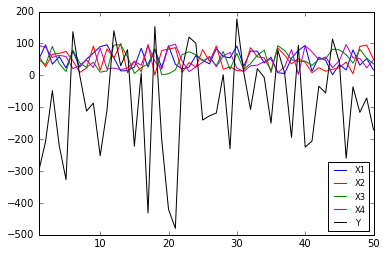

In [5]:
style = {'X1' : 'b', 'X2' : 'r', 'X3' : 'g', 'X4' : 'm', 'Y' : 'k'}
data.plot.line(style=style)

In [6]:
# Multiple linear regression model
def mlr(formula='Y ~ X', data=None, verbose=True):
    lm = smf.ols(formula=formula, data=data).fit()
    Y_regr = lm.predict()
    if verbose:
        display(lm.summary())
    return lm, Y_regr

In [7]:
lm, Y_regr = mlr(formula='Y ~ X1 + X2 + X3 + X4', data=data)
data['Y_regr'] = Y_regr

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.842e+31
Date:                Thu, 14 Sep 2017   Prob (F-statistic):               0.00
Time:                        21:55:18   Log-Likelihood:                 1415.4
No. Observations:                  50   AIC:                            -2821.
Df Residuals:                      45   BIC:                            -2811.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   3.197e-14   8.02e-14      0.399      0.692      -1.3e-13  1.93e-13
X1             1.0000   6.94e-16   1.44e+15      0.000         1.000     1.000
X2            -2.0000   6.05e-16  -3.31e+15      0.000        -2.000    -2.000
X3             3.0000   7.47e-16   4.02e+15      0.000         3.000     3.000
X4            -4.0000   7.32e-16  -5.47e+15      0.000        -4.000    -4.000
==============================================================================
Omnibus:                        2.634   Durbin-Watson:                   0.955
Prob(Omnibus):                  0.268   Jarque-Bera (JB):                1.508
Skew:                           0.095   Prob(JB):                        0.471
Kurtosis:                       2.171   Cond. No.                         434.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

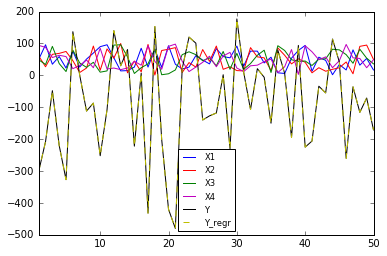

In [8]:
style['Y_regr'] = 'y--'
data.plot.line(style=style)

Instead of using `smf.ols()` lets derive the coefficients from  minimizing sum of squared errors (SSE) with respect to a 
$a=(X^T X)^{-1} X^T y$

In [9]:
def calc_coeffs(X, Y):
    return np.dot(np.linalg.inv(np.dot(X.transpose(), X)), np.dot(X.transpose(), Y))
areg = calc_coeffs(X, Y)
areg

array([ 1., -2.,  3., -4.])

Can't find a direct equivalent of Matlab's stepwisefit() function in any of the Python stats modules.  Could write a function myself to mimic the Matlab code:
```
% applying stepwise regression on Y and X
[a SE PVAL INMODEL STATS NEXTSTEP HISTORY]=stepwisefit(X,Y);
% constant coefficient 
a0_st=STATS.intercept

```

In [10]:
# Simple linear regression between Y and Y_regr

def corrcoef(x1, x2, verbose=True):
    """Return correlation coeff and p-value"""
    m, b0, r, p, stderr = scipy.stats.linregress(x1, x2)
    if verbose:
        print('Correlation coefficient: %f' % r)
        print('p-value: %f' % p)
    return r, p

def scatterplot(data, xname, yname):
    """Scatter plot and one-to-one line"""
    x, y = data[xname], data[yname]
    r, p = corrcoef(x, y)
    data.plot.scatter(x=xname, y=yname)
    plt.title('r=%.2f' % r)
    combo = np.concatenate((x, y))
    xline = np.arange(min(combo), max(combo) + 1)
    plt.plot(xline, xline, 'k')

Correlation coefficient: 1.000000
p-value: 0.000000


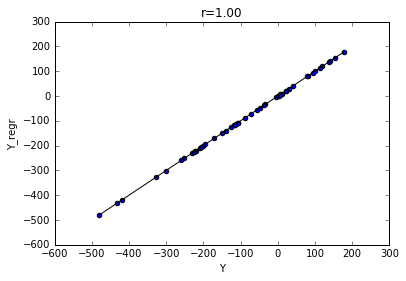

In [11]:
scatterplot(data, 'Y', 'Y_regr')

### Example 2

Create artificial data set based on:
$Y = a_0 + a_1X_1 + a_2X_2 + a_3X_3 + a_4X_4 + Y_{rand}$

In [12]:
Yrand = readmat('Yrand.mat', 'Yrand')
Yrand = Yrand.flatten()
Ynew = Y + 5 * Yrand
data = data.drop('Y_regr', axis=1)
data['Ynew'] = Ynew
data.head()

,X1,X2,X3,X4,Y,Ynew
1,50.0,61.0,49.0,94.0,-301.0,44.0
2,96.0,27.0,34.0,88.0,-208.0,192.0
3,35.0,66.0,91.0,56.0,-48.0,127.0
4,59.0,69.0,37.0,63.0,-220.0,-90.0
5,23.0,75.0,12.0,59.0,-327.0,-152.0


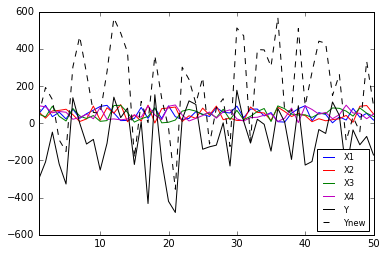

In [13]:
style['Ynew'] = 'k--'
data.plot.line(style=style)

In [14]:
# Multiple linear regression model
lm, Y_regr = mlr(formula='Ynew ~ X1 + X2 + X3 + X4', data=data)
data['Y_regr'] = Y_regr

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ynew   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     11.78
Date:                Thu, 14 Sep 2017   Prob (F-statistic):           1.25e-06
Time:                        21:55:19   Log-Likelihood:                -322.34
No. Observations:                  50   AIC:                             654.7
Df Residuals:                      45   BIC:                             664.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    311.3389     99.440      3.131      0.003       111.057   511.621
X1             1.0298      0.860      1.197      0.238        -0.703     2.762
X2            -2.0571      0.750     -2.743      0.009        -3.567    -0.547
X3             2.4550      0.926      2.651      0.011         0.590     4.320
X4            -4.3413      0.908     -4.783      0.000        -6.170    -2.513
==============================================================================
Omnibus:                       16.014   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                3.663
Skew:                          -0.188   Prob(JB):                        0.160
Kurtosis:                       1.728   Cond. No.                         434.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

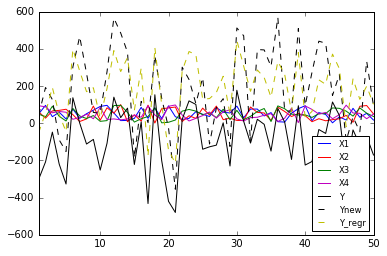

In [15]:
data.plot.line(style=style)

Correlation coefficient: 0.715219
p-value: 0.000000


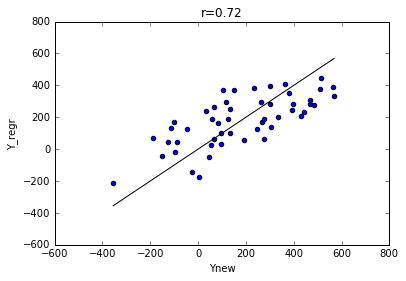

In [16]:
scatterplot(data, 'Ynew', 'Y_regr')

#### Option 2: Cross validation

Split the data into calibration sample and validation sample

In [17]:
isplit = 25
data_cal = data.iloc[:isplit]
data_val = data.iloc[isplit:]

In [18]:
print('Calibration Data:')
display(data_cal)
print('\nValidation Data:')
display(data_val)

Calibration Data:


,X1,X2,X3,X4,Y,Ynew,Y_regr
1,50.0,61.0,49.0,94.0,-301.0,44.0,-50.447862
2,96.0,27.0,34.0,88.0,-208.0,192.0,56.086482
3,35.0,66.0,91.0,56.0,-48.0,127.0,191.898879
4,59.0,69.0,37.0,63.0,-220.0,-90.0,47.485487
5,23.0,75.0,12.0,59.0,-327.0,-152.0,-45.937334
6,76.0,46.0,79.0,21.0,137.0,302.0,397.748796
7,26.0,9.0,39.0,31.0,1.0,466.0,280.760873
8,51.0,23.0,25.0,48.0,-112.0,268.0,169.533953
9,70.0,92.0,41.0,24.0,-87.0,58.0,190.632000
10,90.0,16.0,10.0,85.0,-252.0,53.0,26.640985



Validation Data:


,X1,X2,X3,X4,Y,Ynew,Y_regr
26,36.0,44.0,55.0,60.0,-127.0,-112.0,132.440980
27,84.0,92.0,30.0,27.0,-118.0,82.0,165.020367
28,59.0,19.0,75.0,61.0,2.0,132.0,252.310645
29,55.0,27.0,19.0,72.0,-230.0,-125.0,46.502880
30,92.0,15.0,69.0,23.0,177.0,512.0,444.762696
31,29.0,14.0,19.0,12.0,10.0,470.0,306.951170
32,76.0,87.0,37.0,30.0,-107.0,-102.0,171.228248
33,76.0,58.0,63.0,32.0,21.0,396.0,286.029817
34,39.0,55.0,79.0,43.0,-6.0,394.0,245.623919
35,57.0,15.0,9.0,51.0,-150.0,305.0,139.866066


In [19]:
v0 = ['X1', 'X2', 'X3', 'X4']
combos = []
for i, v in enumerate(v0):
    combos = combos + list(itertools.combinations(v0, i + 1))
print(combos)

[('X1',), ('X2',), ('X3',), ('X4',), ('X1', 'X2'), ('X1', 'X3'), ('X1', 'X4'), ('X2', 'X3'), ('X2', 'X4'), ('X3', 'X4'), ('X1', 'X2', 'X3'), ('X1', 'X2', 'X4'), ('X1', 'X3', 'X4'), ('X2', 'X3', 'X4'), ('X1', 'X2', 'X3', 'X4')]


In [20]:
def get_formula(pred_list, response='Ynew'):
    """Return regression formula for list of predictor indices"""
    return response + ' ~ ' + ' + '.join([pred for pred in pred_list])

In [21]:
formulas = [get_formula(combo) for combo in combos]
formulas

['Ynew ~ X1',
 'Ynew ~ X2',
 'Ynew ~ X3',
 'Ynew ~ X4',
 'Ynew ~ X1 + X2',
 'Ynew ~ X1 + X3',
 'Ynew ~ X1 + X4',
 'Ynew ~ X2 + X3',
 'Ynew ~ X2 + X4',
 'Ynew ~ X3 + X4',
 'Ynew ~ X1 + X2 + X3',
 'Ynew ~ X1 + X2 + X4',
 'Ynew ~ X1 + X3 + X4',
 'Ynew ~ X2 + X3 + X4',
 'Ynew ~ X1 + X2 + X3 + X4']

In [22]:
def cross_validate(data_cal, data_val, formula='', response='Ynew'):
    lm = smf.ols(formula=formula, data=data_cal).fit()
    Yval = lm.predict(data_val)
    r_val, p_val = corrcoef(data_val[response], Yval, verbose=False)
    return r_val, p_val

In [23]:
r_vals, p_vals = [], []
for formula in formulas:
    print('Cross validate for ' + formula)
    r, p = cross_validate(data_cal, data_val, formula=formula)
    r_vals.append(r)
    p_vals.append(p)

Cross validate for Ynew ~ X1
Cross validate for Ynew ~ X2
Cross validate for Ynew ~ X3
Cross validate for Ynew ~ X4
Cross validate for Ynew ~ X1 + X2
Cross validate for Ynew ~ X1 + X3
Cross validate for Ynew ~ X1 + X4
Cross validate for Ynew ~ X2 + X3
Cross validate for Ynew ~ X2 + X4
Cross validate for Ynew ~ X3 + X4
Cross validate for Ynew ~ X1 + X2 + X3
Cross validate for Ynew ~ X1 + X2 + X4
Cross validate for Ynew ~ X1 + X3 + X4
Cross validate for Ynew ~ X2 + X3 + X4
Cross validate for Ynew ~ X1 + X2 + X3 + X4


In [24]:
results = pd.DataFrame(index=formulas, columns=['r_val', 'p_val'])
results['r_val'] = r_vals
results['p_val'] = p_vals
results

,r_val,p_val
Ynew ~ X1,-0.056218,0.789538
Ynew ~ X2,0.146903,0.483475
Ynew ~ X3,0.133970,0.523184
Ynew ~ X4,0.558336,0.003724
Ynew ~ X1 + X2,0.131546,0.530796
Ynew ~ X1 + X3,0.154472,0.460964
Ynew ~ X1 + X4,0.560260,0.003583
Ynew ~ X2 + X3,0.211903,0.309210
Ynew ~ X2 + X4,0.659297,0.000338
Ynew ~ X3 + X4,0.464491,0.019324


In [25]:
formula_best = results.idxmin()['p_val']
formula_best

'Ynew ~ X1 + X2 + X4'

In [26]:
lm_best, _ = mlr(formula=formula_best, data=data_cal)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Ynew   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     5.581
Date:                Thu, 14 Sep 2017   Prob (F-statistic):            0.00562
Time:                        21:55:21   Log-Likelihood:                -162.66
No. Observations:                  25   AIC:                             333.3
Df Residuals:                      21   BIC:                             338.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    439.6565    107.157      4.103      0.001       216.812   662.501
X1             0.4533      1.336      0.339      0.738        -2.326     3.232
X2            -1.7454      1.145     -1.524      0.142        -4.127     0.636
X4            -4.5245      1.319     -3.430      0.003        -7.267    -1.782
==============================================================================
Omnibus:                        0.283   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.868   Jarque-Bera (JB):                0.435
Skew:                          -0.197   Prob(JB):                        0.805
Kurtosis:                       2.488   Cond. No.                         280.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
Yfinal = lm_best.predict(data)
rfinal, pfinal = corrcoef(Ynew, Yfinal)
data['Yfinal'] = Yfinal
data.head()

Correlation coefficient: 0.659232
p-value: 0.000000


,X1,X2,X3,X4,Y,Ynew,Y_regr,Yfinal
1,50.0,61.0,49.0,94.0,-301.0,44.0,-50.447862,-69.451755
2,96.0,27.0,34.0,88.0,-208.0,192.0,56.086482,37.888066
3,35.0,66.0,91.0,56.0,-48.0,127.0,191.898879,86.953056
4,59.0,69.0,37.0,63.0,-220.0,-90.0,47.485487,60.923486
5,23.0,75.0,12.0,59.0,-327.0,-152.0,-45.937334,52.232047


Correlation coefficient: 0.659232
p-value: 0.000000


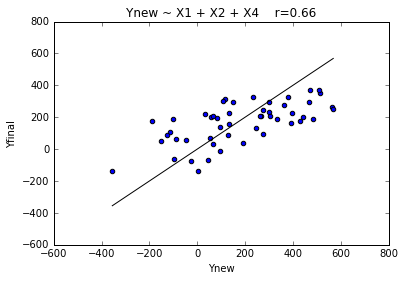

In [28]:
scatterplot(data, 'Ynew', 'Yfinal')
plt.title(formula_best + '    r=%.2f' % rfinal)